# Analysis of all DBTL cycles

This notebook generates a set of media designs using Latin Hypercube sampling as well as ART trained on previous cycles. We use ART's capability to provide this kind of designs for media components for which to get phenotypic data. We will use absorbance at 340nm as assay for this experiment.  


We include a design that is very close to the standard media (up to 10% variation for each component), as a control for every cycle.

Tested using **ART_3.9** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`

**File generated by running this notebook**
- `recommendations_initial.csv`

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [43]:
import os
import sys
# sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../../media_compiler')
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from art.core import RecommendationEngine 
import art.plot as plot
import edd_utils as eddu
from core import designs_pairwise


In [2]:
warnings.filterwarnings("ignore")

## User parameters

In [3]:
user_params = {
    'bounds_file': f'../data/Putida_media_bounds_extended.csv',
    'output_file_path': f'../data/all_DBTL', # Folder for output files,
    'standard_media_file': '../data/standard_recipe_concentrations_extended.csv',
    'study_slug_1': 'combinatorial-media-for-flaviolin-dbtl1-ed1e',
    'study_slug_2': 'combinatorial-media-for-flaviolin-dbtl-2',
    'study_slug_3': 'combinatorial-media-for-flaviolin-dbtl-3',
    'study_slug_4': 'combinatorial-media-for-flaviolin-dbtl-4',
    'study_slug_5': 'combinatorial-media-for-flaviolin-dbtl-5',
    'study_slug_6': 'combinatorial-media-for-flaviolin-dbtl-6',
    'study_slug_7': 'combinatorial-media-for-flaviolin-dbtl-7',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
    'art_model_directory': '../data/DBTL/'
}

In [41]:
os.makedirs(user_params['output_file_path'], exist_ok=True) 

Specify which components to explore:

In [4]:
user_params['components'] = [
    'H3BO3[mM]',
    'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    'CaCl2[mM]'    
]

user_params['response_intermed'] = 'OD340'
user_params['response'] = 'OD340_yield'

In [5]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [6]:
df_stand

,Concentration,Solubility
Component,,
MOPS[mM],40.00000,2389.37
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,763.38
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,688.47
K2HPO4[mM],1.32000,9185.90
FeSO4[mM],0.01000,1438.75
NH4Cl[mM],9.52000,5290.71
MgCl2[mM],0.52000,11558.70


### Load the data

In [7]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']
study_slug_5 = user_params['study_slug_5']
study_slug_6 = user_params['study_slug_6']
study_slug_7 = user_params['study_slug_7']

edd_server = user_params['edd_server']
username = user_params['username']

In [8]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [9]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    df_5 = eddu.export_study(session, study_slug_5, edd_server=edd_server)
    df_6 = eddu.export_study(session, study_slug_6, edd_server=edd_server)
    df_7 = eddu.export_study(session, study_slug_7, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')


100%|██████████| 48/48 [00:00<00:00, 1541.99it/s]


Concatenate the six studies (which did not include units in `Line Description` and the measurement type was stored in `Protocol`):

In [10]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])

In [11]:
df.head(2)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,148494,Combinatorial media for flaviolin DBTL1,148495,73b42c69-2d7f-486d-a8c4-b0be76916247,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148543,C1_WA1_A4-R1,NaN,Optical Density,0,NaN,0.4422,48.0
1,148494,Combinatorial media for flaviolin DBTL1,148496,938f921b-52c3-4aa6-bfef-d869fd71ac18,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,148544,C1_WA1_A4-R2,NaN,Optical Density,0,NaN,0.3405,48.0


In [12]:
df_7.head(2)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,173217,Combinatorial media for flaviolin DBTL 7,173218,d7341daf-8208-4880-948a-9592fe69baa3,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173266,C7_WA1_C1-R1,NaN,OD340,0,NaN,0.0309,48.0
1,173217,Combinatorial media for flaviolin DBTL 7,173219,7fe64521-5051-4904-a562-05e7cacc7f15,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173267,C7_WA1_C1-R2,NaN,OD340,0,NaN,0.0222,48.0


Drop unnecessary columns:

In [13]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.rename(columns={'Protocol': 'Measurement Type'}, inplace=True)
df.head(2)

,Line Name,Line Description,Measurement Type,Value
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4422
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.3405


In [14]:
df_7 = df_7.loc[:,['Line Name','Line Description','Measurement Type','Value']]
df_7.head(2)

,Line Name,Line Description,Measurement Type,Value
0,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0309
1,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0222


Pivot the dataframe to include columns for all protocols:

In [15]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")
df.reset_index(inplace=True)
df.head()

Measurement Type,Line Name,Line Description,OD340,OD600
0,C1_WA1_A4-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.4422,2.019
1,C1_WA1_A4-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3405,0.516
2,C1_WA1_A4-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3397,0.436
3,C1_WA1_A4-R4,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.3602,0.623
4,C1_WA5_A8-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",0.2699,0.699


DBTL 7 only has OD340 measurements.

In [16]:
df_7.rename(columns={'Value': 'OD340'}, inplace=True)
df_7.drop(columns='Measurement Type', inplace=True)
df_7.head()

,Line Name,Line Description,OD340
0,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0309
1,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0222
2,C7_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0154
3,C7_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0035
4,C7_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.0000


#### Adding media information to the data frame

Add columns for each component:

In [17]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
    
components = re.split(': |, ', df_7['Line Description'][0])[::2]
for comp in components:
    df_7[comp] = None


And assign values for each component and line:

In [18]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (4+c)] = float(value)

df.drop(columns='Line Description', inplace=True)
df.tail()

Measurement Type,Line Name,OD340,OD600,MOPS,Tricine,H3BO3,Glucose,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4
283,C6_WD7_F7-R2,0.3230,0.621,40.0,4.0,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
284,C6_WD7_F7-R3,0.3304,0.424,40.0,4.0,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867
285,C6_WD8_F8-R1,0.2993,1.064,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103
286,C6_WD8_F8-R2,0.3000,0.980,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103
287,C6_WD8_F8-R3,0.2958,1.275,40.0,4.0,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.20097,0.000028,0.000316,0.000091,0.000777,0.000103


In [19]:
for i in range(len(df_7)):
    values = re.split(': |, ', df_7['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df_7.iloc[i, (3+c)] = float(value)

df_7.drop(columns='Line Description', inplace=True)
df_7.tail()

,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM]
43,C7_WA8_C8-R2,0.0330,40.0,4.0,0.023089,191.921217,0.129778,10.082546,0.048329,25.802273,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696
44,C7_WA8_C8-R3,0.0233,40.0,4.0,0.023089,191.921217,0.129778,10.082546,0.048329,25.802273,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696
45,C7_WD8_F8-R1,0.2638,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0
46,C7_WD8_F8-R2,0.2765,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0
47,C7_WD8_F8-R3,0.3008,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,9.359875,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0


#### Include units into column names to match the new format from DBTL 7

In [20]:
comp = df.columns.drop(['Line Name', 'OD340', 'OD600'])
comp_units = [f'{col}[mM]' for col in comp]
col_rename = dict(zip(comp, comp_units))

df.rename(columns=col_rename, inplace=True)


#### Include CaCl2 value into all previous cycles

In [21]:
df["CaCl2[mM]"] = 0

In [22]:
df.head(1)

Measurement Type,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM]
0,C1_WA1_A4-R1,0.4422,2.019,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0


Append the DBTL 7 data

In [23]:
df = pd.concat([df, df_7])
df.reset_index(drop=True, inplace=True)

Include the Yield column:

In [28]:
df['OD340_yield'] = df['OD340'] / df['Glucose[mM]']

In [70]:
df['OD340_yield'] = pd.to_numeric(df['OD340_yield'])

Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [29]:
control_lines = df[df['Line Name'].str.find('WF5_F8') > 0]

control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

In [30]:
control_lines

,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340_yield
44,C1_WF5_F8-R1,0.2856,0.731,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0,0.01428
45,C1_WF5_F8-R2,0.2936,0.763,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0,0.01468
46,C1_WF5_F8-R3,0.2715,0.664,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0,0.013575
47,C1_WF5_F8-R4,0.2891,0.795,40.0,4.0,0.003797,20.0,0.31178,1.325974,0.009506,9.927665,0.568441,50.767801,0.00003,0.000296,0.000096,0.000729,0.000102,0,0.014455
92,C2_WF5_F8-R1,0.2934,0.631,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0,0.01467
93,C2_WF5_F8-R2,0.2912,0.593,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0,0.01456
94,C2_WF5_F8-R3,0.3004,0.601,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0,0.01502
95,C2_WF5_F8-R4,0.2990,0.671,40.0,4.0,0.003929,20.0,0.279019,1.232969,0.010158,9.510727,0.483299,47.544745,0.000027,0.000288,0.000104,0.000759,0.000095,0,0.01495
141,C3_WD8_F8-R1,0.2813,1.022,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0,0.014065
142,C3_WD8_F8-R2,0.2755,0.800,40.0,4.0,0.003709,20.0,0.305525,1.243568,0.009372,9.943037,0.472293,53.326661,0.000029,0.000312,0.000094,0.000849,0.000098,0,0.013775


How many designs improve response over the standard recipe?

In [32]:
control_titer = np.max(control_lines['OD340'])
num_improved_titer = np.sum(df['OD340'] > control_titer)
num_designs = len(df) - len(control_lines)
print(f'{num_improved_titer} samples out of {num_designs} improve over the standard in terms of Titer ({num_improved_titer/num_designs*100:.2f}%).')

control_yield = np.max(control_lines['OD340_yield'])
num_improved_yield = np.sum(df['OD340_yield'] > control_yield)
print(f'{num_improved_yield} samples out of {num_designs} improve over the standard in terms of Yield ({num_improved_yield/num_designs*100:.2f}%).')


222 samples out of 313 improve over the standard in terms of Titer (70.93%).
217 samples out of 313 improve over the standard in terms of Yield (69.33%).


In [33]:
df.head(1)

,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340_yield
0,C1_WA1_A4-R1,0.4422,2.019,40.0,4.0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.02211


Add cycle number:

In [37]:
find_cycle = lambda x: re.split('_', x['Line Name'])[0][1:]
df['Cycle'] =  df.apply(find_cycle, axis=1)

In [40]:
df.tail()

,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],...,MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340_yield,Cycle
331,C7_WA8_C8-R2,0.0330,NaN,40.0,4.0,0.023089,191.921217,0.129778,10.082546,0.048329,...,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696,0.000172,7
332,C7_WA8_C8-R3,0.0233,NaN,40.0,4.0,0.023089,191.921217,0.129778,10.082546,0.048329,...,1.886212,1672.460716,0.000485,0.002339,0.001446,0.014888,0.001487,0.005696,0.000121,7
333,C7_WD8_F8-R1,0.2638,NaN,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,...,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0,0.012744,7
334,C7_WD8_F8-R2,0.2765,NaN,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,...,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0,0.013357,7
335,C7_WD8_F8-R3,0.3008,NaN,40.0,4.0,0.003686,20.699982,0.279631,1.33523,0.009901,...,0.471481,52.92838,0.000029,0.000285,0.000095,0.000746,0.000094,0.0,0.014531,7


In [76]:
titer_control_mean = control_lines['OD340'].mean()
yield_control_mean = control_lines['OD340_yield'].mean()


In [61]:
def plot_all_cycles(response='yield'):
    
    if response=='yield':
        response_var = 'OD340_yield'
        control_mean = yield_control_mean
    elif response=='titer':
        response_var = 'OD340'
        control_mean = titer_control_mean
    else:
        raise "Response type not known."
        
    fig, ax = plt.subplots(figsize=(6, 5))
    fontsize = 16
    sns.set(font_scale = 1.5)
    sns.set_style("whitegrid")
    sns.swarmplot(data=df, 
                  linewidth=0,
                  x='Cycle',
                  y=response_var,
                  color="salmon"
                  )
    sns.despine(left=True, bottom=True)
    ax.set(xlabel="DBTL", ylabel=response_var)
    sns.lineplot(
        x=ax.get_xlim(), 
        y=[control_mean, control_mean],
        color='k',
        linestyle='dashed',
        linewidth=2
    )

    fig.savefig(
        f"{user_params['output_file_path']}/{response_var}_cycles.png",
        transparent=False,
        bbox_inches="tight",
        dpi=300,
    )

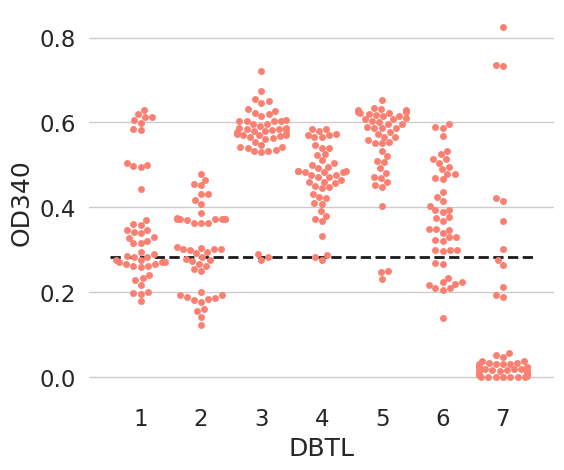

In [63]:
plot_all_cycles('titer')

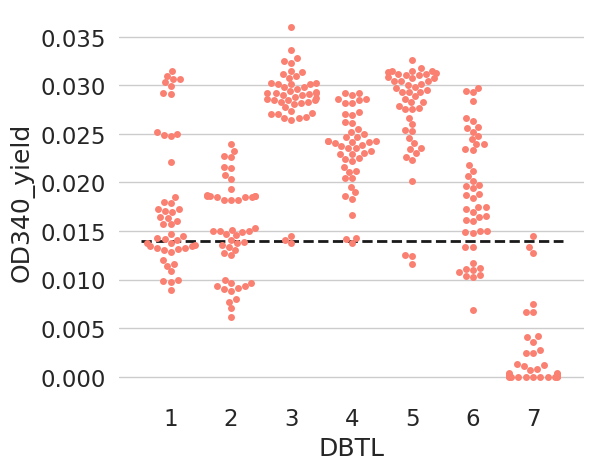

In [64]:
plot_all_cycles('yield')

In [66]:
titer_max_ind = df['OD340'].nlargest(3).index
df.loc[titer_max_ind]

,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],...,MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340_yield,Cycle
320,C7_WA6_C6-R3,0.8254,NaN,40.0,4.0,0.057934,110.380997,0.286511,6.340137,0.093384,...,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.007478,7
318,C7_WA6_C6-R1,0.7352,NaN,40.0,4.0,0.057934,110.380997,0.286511,6.340137,0.093384,...,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.006661,7
319,C7_WA6_C6-R2,0.7320,NaN,40.0,4.0,0.057934,110.380997,0.286511,6.340137,0.093384,...,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.006632,7


In [72]:
yield_max_ind = df['OD340_yield'].nlargest(1).index
df.loc[yield_max_ind]

,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],...,MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340_yield,Cycle
96,C3_WA1_C1-R1,0.7206,1.492,40.0,4.0,0.028304,20.0,0.203775,2.142815,0.04985,...,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0,0.03603,3


In [73]:
df.loc[int((yield_max_ind).values):int((yield_max_ind).values)+2]

,Line Name,OD340,OD600,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],...,MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340_yield,Cycle
96,C3_WA1_C1-R1,0.7206,1.492,40.0,4.0,0.028304,20.0,0.203775,2.142815,0.04985,...,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0,0.036030,3
97,C3_WA1_C1-R2,0.6227,1.016,40.0,4.0,0.028304,20.0,0.203775,2.142815,0.04985,...,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0,0.031135,3
98,C3_WA1_C1-R3,0.6467,1.299,40.0,4.0,0.028304,20.0,0.203775,2.142815,0.04985,...,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0,0.032335,3


In [74]:
titer_max = df.loc[titer_max_ind]['OD340'].mean()
yield_max = (
    df.loc[int((yield_max_ind).values):int((yield_max_ind).values)+2]['OD340_yield']
).mean()

In [78]:
improvement = 100*(titer_max/titer_control_mean-1)
f'Improvement in titer over the control: {improvement:.2f}%'


'Improvement in titer over the control: 171.23%'

In [79]:
improvement = 100*(yield_max/yield_control_mean-1)
f'Improvement in yield over the control: {improvement:.2f}%'

'Improvement in yield over the control: 136.47%'